# **Word-Level Recurrent Neural Network Language Model**

## **From Scratch Implementation in NumPy**

This notebook implements a **vanilla RNN** for word-level language modeling.
### **What We'll Build:**
- **Vanilla RNN** with tanh activation
- **Word embeddings** for efficient vocabulary representation
- **Backpropagation Through Time (BPTT)** for gradient computation
- **Adam optimizer** for parameter updates
- **Word-level text generation** from learned patterns

---
*Notebook by*: Ahmad Raza [@ahmadrazacdx](https://github.com/ahmadrazacdx)<br>
*Date: 2025*  
*License: MIT*

In [1]:
import re
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

### __DATA I/O__
We will use `Thirsty Crow` story as our small training data, but now tokenized at the **word level**.

In [2]:
data = open('../data/thirsty_crow.txt', 'r').read()
words = re.findall(r"\w+|[.,!?'\";:]", data.lower())
SOS_TOKEN = '<SOS>'  # Start of Sequence
EOS_TOKEN = '<EOS>'  # End of Sequence
UNK_TOKEN = '<UNK>'  # Unknown word
vocab = [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted(list(set(words)))
data_size, vocab_size = len(words), len(vocab)
print(f'Data has {data_size} words, {vocab_size} unique (including special tokens).')
print(f'Special tokens: {vocab[:3]}')
print(f'Sample words: {vocab[3:13]}')

Data has 148 words, 90 unique (including special tokens).
Special tokens: ['<SOS>', '<EOS>', '<UNK>']
Sample words: ['!', ',', '.', 'a', 'after', 'an', 'and', 'at', 'away', 'beak']


In [3]:
word_to_ix = {w: i for i, w in enumerate(vocab)}

In [4]:
ix_to_word = {i: w for i, w in enumerate(vocab)}

**Understanding the Mappings:**
- `word_to_ix`: Maps ```{'<SOS>': 0, '<EOS>': 1, '<UNK>': 2, 'a': 3, 'crow': 4, ...}```
- `ix_to_word`: Reverse mapping: ```{0: '<SOS>', 1: '<EOS>', 2: '<UNK>', 3: 'a', ...}```

**Special Tokens:**
- **`<SOS>`**: Marks the beginning of a sequence (useful for generation)
- **`<EOS>`**: Marks the end of a sequence (helps model learn when to stop)
- **`<UNK>`**: Represents out-of-vocabulary words at test time

**Example:** The phrase "the cat sat" becomes `[45, 12, 38]` if ```{'the': 45, 'cat': 12, 'sat': 38}``` in our vocabulary.

### __HYPER-PARAMETERS__

In [5]:
lr = 1e-3 # learning rate
seq_len = 25 # times RNN will be unrolled (Timesteps) -words in one seq
hidden_size = 100 # size of hidden units
embed_size = 100 # size of word embedding vector

**Hyperparameter Guide:**
- **`embed_size`**: Dimension of word embedding vectors
  - Maps words to dense continuous vectors
  - Typical range: 50-300 (smaller vocab → smaller embeddings)
  - Much more efficient than one-hot encoding for large vocabularies!

### __MODEL PARAM INIT__
**Initializing weight matrices for the RNN with word embeddings.**

- $\mathbf{W}_{emb} \in \mathbb{R}^{V \times E}$ Word embedding matrix (lookup table)
- $\mathbf{W}_{eh} \in \mathbb{R}^{H \times E}$ Embedding-to-hidden weights
- $\mathbf{W}_{hh} \in \mathbb{R}^{H \times H}$ Hidden-to-hidden (recurrent) weights
- $\mathbf{W}_{hy} \in \mathbb{R}^{V \times H}$ Hidden-to-output weights
- $\mathbf{b}_h \in \mathbb{R}^{H \times 1}$ Hidden bias
- $\mathbf{b}_y \in \mathbb{R}^{V \times 1}$ Output bias

**Where:**  
- $V$ = vocabulary size  
- $E$ = embedding dimension  
- $H$ = hidden size

In [6]:
Wemb = np.random.randn(vocab_size, embed_size) * 0.01 # word embeddings (V, E)
Weh = np.random.randn(hidden_size, embed_size) * 0.01 # embedding to hidden (H, E)
Whh = np.random.randn(hidden_size, hidden_size) * 0.01 # hidden to hidden (H, H)
Why = np.random.randn(vocab_size, hidden_size) * 0.01 # hidden to output (V, H)
bh = np.zeros((hidden_size, 1)) # hidden bias (H, 1)
by = np.zeros((vocab_size, 1)) # output bias (V, 1)

In [7]:
print(f"""
Wemb: Word embeddings  : {Wemb.shape}
Weh: Embedding to hidden: {Weh.shape}
Whh: Hidden to hidden : {Whh.shape}
Why: Hidden to output : {Why.shape}
bh: Hidden bias       : {bh.shape}
by: Output bias       : {by.shape}
""")


Wemb: Word embeddings  : (90, 100)
Weh: Embedding to hidden: (100, 100)
Whh: Hidden to hidden : (100, 100)
Why: Hidden to output : (90, 100)
bh: Hidden bias       : (100, 1)
by: Output bias       : (90, 1)



### __ADAM OPTIMIZER INITIALIZATION__

In [8]:
# Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Adam memory variables (first moment)
mWemb = np.zeros_like(Wemb)
mWeh = np.zeros_like(Weh)
mWhh = np.zeros_like(Whh)
mWhy = np.zeros_like(Why)
mbh = np.zeros_like(bh)
mby = np.zeros_like(by)

# Adam memory variables (second moment)
vWemb = np.zeros_like(Wemb)
vWeh = np.zeros_like(Weh)
vWhh = np.zeros_like(Whh)
vWhy = np.zeros_like(Why)
vbh = np.zeros_like(bh)
vby = np.zeros_like(by)

# Timestep counter for bias correction
t_adam = 0

### __SINGLE VANILLA RNN CELL WITH WORD EMBEDDINGS__

**Forward pass equations:**

$$
\begin{align}
\mathbf{e}_t &= \mathbf{W}_{emb}[word\_idx] \quad &\text{(word embedding lookup)} \\
\mathbf{z}_t &= \mathbf{W}_{eh} \mathbf{e}_t + \mathbf{W}_{hh} \mathbf{h}_{t-1} + \mathbf{b}_h \quad &\text{(pre-activation)} \\
\mathbf{h}_t &= \tanh(\mathbf{z}_t) \quad &\text{(hidden state)} \\
\mathbf{y}_t &= \mathbf{W}_{hy} \mathbf{h}_t + \mathbf{b}_y \quad &\text{(output logits)}
\end{align}
$$

**Key difference from char-level:** Instead of one-hot input, we lookup a dense embedding vector!

In [9]:
def rnn(word_idx, h_prev):
    """
    Single RNN cell with embedding lookup

    Inputs:
        - word_idx: Integer index of word in vocabulary
        - h_prev: Previous hidden state (H, 1)

    Returns:
        - ht: Current hidden state (H, 1)
        - yt: Output logits (V, 1)
        - et: Word embedding (E, 1)
    """
    et = Wemb[word_idx].reshape(-1, 1)  # (E, 1)
    zt = np.dot(Weh, et) + np.dot(Whh, h_prev) + bh  # (H, E)@(E,1):(H,1),(H,H)@(H,1):(H,1) + (H,1) = (H,1)
    ht = np.tanh(zt)  # (H, 1)
    yt = np.dot(Why, ht) + by  # (V,H)@(H,1):(V, 1)+(V,1)=(V,1)
    return ht, yt, et

**Understanding the RNN Cell with Embeddings:**

**What's happening here?**
- At each timestep $t$, the RNN takes two inputs:
  1. Current word index → lookup in $\mathbf{W}_{emb}$ to get dense vector $\mathbf{e}_t$
  2. Previous memory $\mathbf{h}_{t-1}$ (hidden state from last step)
  
- It outputs:
  1. New memory $\mathbf{h}_t$ (encodes everything seen so far)
  2. Prediction $\mathbf{y}_t$ (logits for next word)
  3. Embedding $\mathbf{e}_t$ (needed for backprop!)

**Why embeddings?**
- **Char-level**: vocab_size = 50-100 → one-hot is fine
- **Word-level**: vocab_size = 10,000+ → one-hot is wasteful!
- Embeddings learn semantic relationships: "king" - "man" + "woman" ≈ "queen"

**The "recurrent" part:** $\mathbf{h}_t$ depends on $\mathbf{h}_{t-1}$, creating a feedback loop through time.

### __FORWARD PASS__


In [10]:
def forward(inputs, targets, h_prev):
    """
    Forward pass through unrolled RNN with word embeddings

    Inputs:
        - inputs: List of word indices, e.g., [5, 8, 12, 12, 15] for "the cat sat sat on"
        - targets: List of target word indices (inputs shifted by 1)
        - h_prev: Initial hidden state from previous sequence, shape (H, 1)

    Returns:
        - word_indices: Dict of word indices {0: idx_0, 1: idx_1, ...}
        - et: Dict of embeddings {0: e_0, 1: e_1, ...}
        - ht: Dict of hidden states {-1: h_init, 0: h_0, 1: h_1, ...}
        - yt: Dict of output logits {0: y_0, 1: y_1, ...}
        - probt: Dict of probability distributions {0: p_0, 1: p_1, ...}
        - loss: Total cross-entropy loss across all timesteps (scalar)
    """
    # Initialize storage dictionaries
    word_indices = {}  # Store word indices
    et = {}  # Store embeddings
    ht = {}  # Store hidden states
    yt = {}  # Store raw outputs (before softmax)
    probt = {}  # Store probability distributions (after softmax)

    # Set initial hidden state
    ht[-1] = np.copy(h_prev)  # (H, 1)
    loss = 0

    # Loop through each timestep in the sequence
    for t in range(len(inputs)):
        # Step 1: Store word index
        word_indices[t] = inputs[t]

        # Step 2: Run RNN cell (forward computation with embedding)
        ht[t], yt[t], et[t] = rnn(word_indices[t], ht[t-1])  # (H, 1), (V, 1), (E, 1)

        # Step 3: Apply softmax to get probabilities
        exp_scores = np.exp(yt[t] - np.max(yt[t]))  # (V, 1)
        probt[t] = exp_scores / np.sum(exp_scores)  # (V, 1)

        # Step 4: Compute loss for this timestep
        # Cross-entropy: -log(probability of correct next word)
        loss += -np.log(probt[t][targets[t], 0] + epsilon)

    return word_indices, et, ht, probt, loss

**Deep Dive: Understanding the Forward Pass with Embeddings**

**1. From one-hot to embeddings**
```python
# Char-level (old):
xt[t] = [0, 0, 1, 0, 0, ..., 0]  # vocab_size = 50, wasteful but okay

# Word-level (new):
word_idx = 2047  # "cat" in vocabulary
et[t] = Wemb[2047]  # Lookup row 2047 → dense vector [0.23, -0.45, 0.67, ...]
# embed_size = 50, much smaller than vocab_size = 10000!
```

**2. Cross-Entropy Loss Formula** (same as before)

$$\mathcal{L}_t = -\log p_t[y^*_t]$$

Where:
- $p_t$: Probability distribution at time $t$ (output of softmax)
- $y^*_t$: Correct next word (target)
- Lower loss → model assigns higher probability to correct word

**Total loss:** $\mathcal{L} = \sum_{t=0}^{T-1} \mathcal{L}_t$

**3. Why maintain hidden state?**

The hidden state $\mathbf{h}_t$ acts as the network's "memory":
- Encodes information about all words seen so far
- Enables the model to learn long-term dependencies
- Without it, predictions would be independent at each position!

**Example:** To predict the next word in "The cat sat on the ___", the model needs to remember "cat" from earlier in the sequence to predict "mat" or "floor".

### __BACKWARD PASS WITH EMBEDDING GRADIENTS__
**Complete BPTT Equations (With Embeddings):**

**Step 1: Output Gradient (Softmax + Cross-Entropy)**
$$\frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} = \mathbf{p}_t - \mathbf{1}_{y^*_t}$$

**Step 2: Output Weight Gradients**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{hy}} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} \mathbf{h}_t^T, \quad \frac{\partial \mathcal{L}}{\partial \mathbf{b}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$

**Step 3: Hidden State Gradient (Two Sources!)**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} = \mathbf{W}_{hy}^T \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t+1}}$$

**Step 4: Pre-Activation Gradient (Tanh)**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot (1 - \mathbf{h}_t^2)$$

**Step 5: Hidden Weight & Embedding Gradients (NEW!)**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{eh}} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t} \mathbf{e}_t^T, \quad \frac{\partial \mathcal{L}}{\partial \mathbf{W}_{hh}} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t} \mathbf{h}_{t-1}^T$$

**Step 6: Embedding Gradient (Backprop to embedding)**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{e}_t} = \mathbf{W}_{eh}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t}$$

**Step 7: Update specific embedding row**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{emb}[word\_idx]} += \frac{\partial \mathcal{L}}{\partial \mathbf{e}_t}$$

**Step 8: Gradient to Previous Timestep**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}} = \mathbf{W}_{hh}^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t}$$

**Visual:** Gradients flow backward from $t=T-1 \rightarrow 0$, accumulating contributions from all timesteps.


In [11]:
def backward(inputs, targets, word_indices, et, ht, probt):
    """
    Backpropagation Through Time (BPTT) with embedding gradients

    Inputs:
        - inputs: List of input word indices
        - targets: List of target word indices
        - word_indices: Dict of word indices from forward pass
        - et: Dict of embeddings from forward pass
        - ht: Dict of hidden states from forward pass
        - probt: Dict of probability distributions from forward pass

    Returns:
        - dWemb: Gradient w.r.t. word embeddings, shape (V, E)
        - dWeh: Gradient w.r.t. embedding-to-hidden weights, shape (H, E)
        - dWhh: Gradient w.r.t. hidden-to-hidden weights, shape (H, H)
        - dWhy: Gradient w.r.t. hidden-to-output weights, shape (V, H)
        - dbh: Gradient w.r.t. hidden bias, shape (H, 1)
        - dby: Gradient w.r.t. output bias, shape (V, 1)
    """
    # Initialize gradients to zero
    dWemb = np.zeros_like(Wemb)
    dWeh, dWhh, dWhy = np.zeros_like(Weh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)

    # Gradient of hidden state at next timestep (initially zero)
    dh_next = np.zeros_like(ht[0]) # (H,1)

    # Backpropagate through time (from last to first timestep)
    for t in reversed(range(len(inputs))):
        # Step 1: Gradient of loss w.r.t output probabilities
        dy = np.copy(probt[t])  # (V, 1)
        dy[targets[t]] -= 1

        # Step 2: Gradients for output layer (Why, by)
        dWhy += np.dot(dy, ht[t].T) # (V,1)@(H,1)->(1,H)=(V,H)
        dby += dy # (V,1)

        # Step 3: Gradient w.r.t hidden state
        # Comes from two sources: current output and next timestep
        dh = np.dot(Why.T, dy) + dh_next # (V,H)->(H,V)@(V,1)=(H,1)+(H,1)=(H,1)

        # Step 4: Gradient through tanh activation
        dzt = (1 - ht[t]**2) * dh  #(H,1)*(H,1)=(H,1)

        # Step 5: Gradients for hidden layer (Weh, Whh, bh)
        dWeh += np.dot(dzt, et[t].T) #(H,1)@(E,1)->(1.E)=(H,E)
        dWhh += np.dot(dzt, ht[t-1].T) #(H,1)@(H,1)->(1,H)=H,H
        dbh += dzt #(H,1)

        # Step 6: Gradient w.r.t embedding
        de = np.dot(Weh.T, dzt)  # (E, H)@(H, 1)=(E, 1)

        # Step 7: Accumulate gradient for specific word in embedding matrix
        dWemb[word_indices[t]] += de.flatten()  # Update row corresponding to word_idx

        # Step 8: Pass gradient to previous timestep
        dh_next = np.dot(Whh.T, dzt)  # (H, H)@(H, 1)=(H, 1)

    # Clip gradients to prevent exploding gradients
    for dparam in [dWemb, dWeh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return dWemb, dWeh, dWhh, dWhy, dbh, dby

**Understanding BPTT with Embeddings: The Gradient Flow**

**1. The Softmax-CrossEntropy Gradient** (same as before)

For softmax activation with cross-entropy loss, the gradient simplifies to:

$$\frac{\partial \mathcal{L}}{\partial \mathbf{y}} = \mathbf{p} - \mathbf{1}_{y^*}$$

Where $\mathbf{1}_{y^*}$ is the one-hot vector of the target.

**2. NEW: Embedding Gradient Flow**

```python
# Gradient flows: loss → output → hidden → embedding
dzt = ...  # Gradient at pre-activation
de = Weh.T @ dzt  # Gradient w.r.t embedding vector (E, 1)
dWemb[word_idx] += de  # Update ONLY the row for this word!
```

**Key insight:** At each timestep, only the embedding row for the current word receives a gradient update, not the entire matrix. However, if the same word appears multiple times in a sequence, its embedding row accumulates gradients from all occurrences. This is more efficient than dense matrix updates for large vocabularies.

**3. Gradient Accumulation**

Notice `+=` instead of `=`:
```python
dWxh += np.dot(dzt, et[t].T)  # Accumulate across timesteps
dWemb[word_idx] += de  # Accumulate for same word appearing multiple times
```
We sum gradients from all timesteps because the same weights are shared across time!


### __UPDATE PARAMS WITH ADAM__

In [12]:
def update_parameters(dWemb, dWeh, dWhh, dWhy, dbh, dby, learning_rate):
    """
    Update model parameters using Adam optimizer

    Inputs:
        - dWemb: Gradient for word embeddings (V, E)
        - dWxh: Gradient for embedding-to-hidden weights (H, E)
        - dWhh: Gradient for hidden-to-hidden weights (H, H)
        - dWhy: Gradient for hidden-to-output weights (V, H)
        - dbh: Gradient for hidden bias (H, 1)
        - dby: Gradient for output bias (V, 1)
        - learning_rate: Step size for parameter updates

    Returns:
        - None (updates global parameters in-place)
    """
    global Wemb, Weh, Whh, Why, bh, by
    global mWemb, mWeh, mWhh, mWhy, mbh, mby
    global vWemb, vWeh, vWhh, vWhy, vbh, vby
    global t_adam

    # Increment timestep
    t_adam += 1

    # Update Wemb
    mWemb = beta1 * mWemb + (1 - beta1) * dWemb
    vWemb = beta2 * vWemb + (1 - beta2) * (dWemb ** 2)
    mWemb_corrected = mWemb / (1 - beta1 ** t_adam)
    vWemb_corrected = vWemb / (1 - beta2 ** t_adam)
    Wemb -= learning_rate * mWemb_corrected / (np.sqrt(vWemb_corrected) + epsilon)

    # Update Weh
    mWeh = beta1 * mWeh + (1 - beta1) * dWeh
    vWeh = beta2 * vWeh + (1 - beta2) * (dWeh ** 2)
    mWeh_corrected = mWeh / (1 - beta1 ** t_adam)
    vWeh_corrected = vWeh / (1 - beta2 ** t_adam)
    Weh -= learning_rate * mWeh_corrected / (np.sqrt(vWeh_corrected) + epsilon)
    # Update Whh
    mWhh = beta1 * mWhh + (1 - beta1) * dWhh
    vWhh = beta2 * vWhh + (1 - beta2) * (dWhh ** 2)
    mWhh_corrected = mWhh / (1 - beta1 ** t_adam)
    vWhh_corrected = vWhh / (1 - beta2 ** t_adam)
    Whh -= learning_rate * mWhh_corrected / (np.sqrt(vWhh_corrected) + epsilon)

    # Update Why
    mWhy = beta1 * mWhy + (1 - beta1) * dWhy
    vWhy = beta2 * vWhy + (1 - beta2) * (dWhy ** 2)
    mWhy_corrected = mWhy / (1 - beta1 ** t_adam)
    vWhy_corrected = vWhy / (1 - beta2 ** t_adam)
    Why -= learning_rate * mWhy_corrected / (np.sqrt(vWhy_corrected) + epsilon)

    # Update bh
    mbh = beta1 * mbh + (1 - beta1) * dbh
    vbh = beta2 * vbh + (1 - beta2) * (dbh ** 2)
    mbh_corrected = mbh / (1 - beta1 ** t_adam)
    vbh_corrected = vbh / (1 - beta2 ** t_adam)
    bh -= learning_rate * mbh_corrected / (np.sqrt(vbh_corrected) + epsilon)

    # Update by
    mby = beta1 * mby + (1 - beta1) * dby
    vby = beta2 * vby + (1 - beta2) * (dby ** 2)
    mby_corrected = mby / (1 - beta1 ** t_adam)
    vby_corrected = vby / (1 - beta2 ** t_adam)
    by -= learning_rate * mby_corrected / (np.sqrt(vby_corrected) + epsilon)

### __TRAIN MODEL__


In [13]:
def train(words_list, num_iterations=1000, print_every=100, sample_every=100):
    """
    Train RNN language model using Adam optimizer

    Inputs:
        - words_list: List of words in training text
        - iterations: Number of training iterations (not full data passes)
        - print_every: Print loss every N iterations
        - sample_every: Generate sample text every N iterations

    Returns:
        - smooth_loss: Exponentially smoothed loss value

    Note: Hidden state h_prev is maintained across sequences for temporal continuity.
        Only reset when reaching end of data or on first iteration.
    """
    smooth_loss = -np.log(1.0 / vocab_size) * seq_len
    losses = []
    n = 0  # Iteration counter
    p = 0  # Data pointer (position in word list)
    h_prev = np.zeros((hidden_size, 1))

    while n < num_iterations:
        # Reset pointer and hidden state at end of data or first iteration
        if p + seq_len + 1 >= len(words_list) or n == 0:
            h_prev = np.zeros((hidden_size, 1))  # Fresh start
            p = 0  # Go back to beginning

        # Input:  words at positions [p, p+1, ..., p+seq_len-1]
        # Target: words at positions [p+1, p+2, ..., p+seq_len]
        inputs = [word_to_ix[w] for w in words_list[p:p+seq_len]]
        targets = [word_to_ix[w] for w in words_list[p+1:p+seq_len+1]]

        # Forward pass (pass hidden state!)
        word_indices, et, ht, probt, loss = forward(inputs, targets, h_prev)
        # Update hidden state for next sequence
        h_prev = np.copy(ht[len(inputs) - 1])
        # Backward pass
        dWemb, dWeh, dWhh, dWhy, dbh, dby = backward(inputs, targets, word_indices, et, ht, probt)
        # Update parameters
        update_parameters(dWemb, dWeh, dWhh, dWhy, dbh, dby, lr)
        # Update smooth loss
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
        # Print progress
        if n % print_every == 0:
            print(f"Iter {n:6d} | Loss: {smooth_loss:.4f}")
        # Generate sample text
        if n % sample_every == 0 and n > 0:
            print(f"\n{'='*60}")
            print(f"SAMPLE at iteration {n}:")
            print(f"{'='*60}")
            sample_text = sample(seed_word=None, n_words=50, use_sos=True, stop_at_eos=True)
            print(sample_text)
            print(f"{'='*60}\n")
        p += seq_len
        n += 1

    print("\nTraining complete!")
    return smooth_loss, losses

### __SAMPLING FUNCTION (GENERATE TEXT)__

In [14]:
def sample(seed_word=None, n_words=50, use_sos=True, stop_at_eos=True):
    """
    Generate text by sampling from the trained RNN language model

    Inputs:
        - seed_word: Starting word for text generation (if None, uses <SOS>)
        - n_words: Maximum number of words to generate (default 50)
        - use_sos: If True and seed_word is None, start with <SOS> token
        - stop_at_eos: If True, stop generation when <EOS> token is sampled

    Returns:
        - String of generated text
    """
    # Initialize with seed word or SOS token
    if seed_word is None:
        if use_sos:
            word_idx = word_to_ix[SOS_TOKEN]
            generated_words = []  # Don't include SOS in output
        else:
            word_idx = word_to_ix[vocab[3]]
            generated_words = [ix_to_word[word_idx]]
    else:
        # Handle seed word not in vocabulary - use UNK token
        word_idx = word_to_ix.get(seed_word.lower(), word_to_ix[UNK_TOKEN])
        if word_idx == word_to_ix[UNK_TOKEN]:
            print(f"Warning: '{seed_word}' not in vocab. Using <UNK> token.")
        generated_words = [ix_to_word[word_idx]]
    h = np.zeros((hidden_size, 1))  # Initialize hidden state

    for _ in range(n_words):
        h, y, e = rnn(word_idx, h)
        p = np.exp(y - np.max(y)) / np.sum(np.exp(y - np.max(y)))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        word = ix_to_word[ix]
        # Check for EOS token
        if stop_at_eos and word == EOS_TOKEN:
            break
        # Skip adding special tokens to output
        if word not in [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]:
            generated_words.append(word)
        word_idx = ix

    return ' '.join(generated_words)

**Understanding Text Generation (Word-Level with Special Tokens)**

**Example:** Suppose after "Once upon a", the model outputs probabilities:

```python
Words: ['time', 'day', 'hill', '<EOS>', 'morning', ...]
Probabilities: [0.65, 0.20, 0.10, 0.03, 0.01, ...]
```

**Sampling:**
- 65% chance pick 'time' → "Once upon a time there"
- 20% chance pick 'day' → "Once upon a day when"  
- 10% chance pick 'hill' → "Once upon a hill sat"
- 3% chance pick '<EOS>' → Stop generation (if `stop_at_eos=True`)
- ...more diverse output!

**Special Tokens in Generation:**
- **`<SOS>`**: Used to initialize generation from scratch
- **`<EOS>`**: Model learns when sequences naturally end
- **`<UNK>`**: Handles unknown words gracefully at test time

**Word-level vs Char-level:**
- **Char-level**: Can generate any word (including typos) → "teh cat"  
- **Word-level**: Only generates known words → more coherent but less creative
- **Word-level**: Faster generation (fewer timesteps)



### __RUN TRAINING__

In [16]:
_, loss = train(words, num_iterations=10000, print_every=500, sample_every=2000)

Iter      0 | Loss: 112.3827
Iter    500 | Loss: 68.1477
Iter   1000 | Loss: 41.3242
Iter   1500 | Loss: 25.0588
Iter   2000 | Loss: 15.1956

SAMPLE at iteration 2000:
, . after flying for a long time , the crow finally saw a pitcher lying under a tree . he quickly flew down and looked inside . there was a little water at the bottom , but his beak could not reach it . the crow thought for a

Iter   2500 | Loss: 9.2147
Iter   3000 | Loss: 5.5879
Iter   3500 | Loss: 3.3886
Iter   4000 | Loss: 2.0550

SAMPLE at iteration 4000:
. the pitcher . slowly , the water began to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow

Iter   4500 | Loss: 1.2462
Iter   5000 | Loss: 0.7558
Iter   5500 | Loss: 0.4584
Iter   6000 | Loss: 0.2780

SAMPLE at iteration 6000:
small water came them sun was flying in search of water . the sun was shinin

### __PLOT LOSS CURVE__

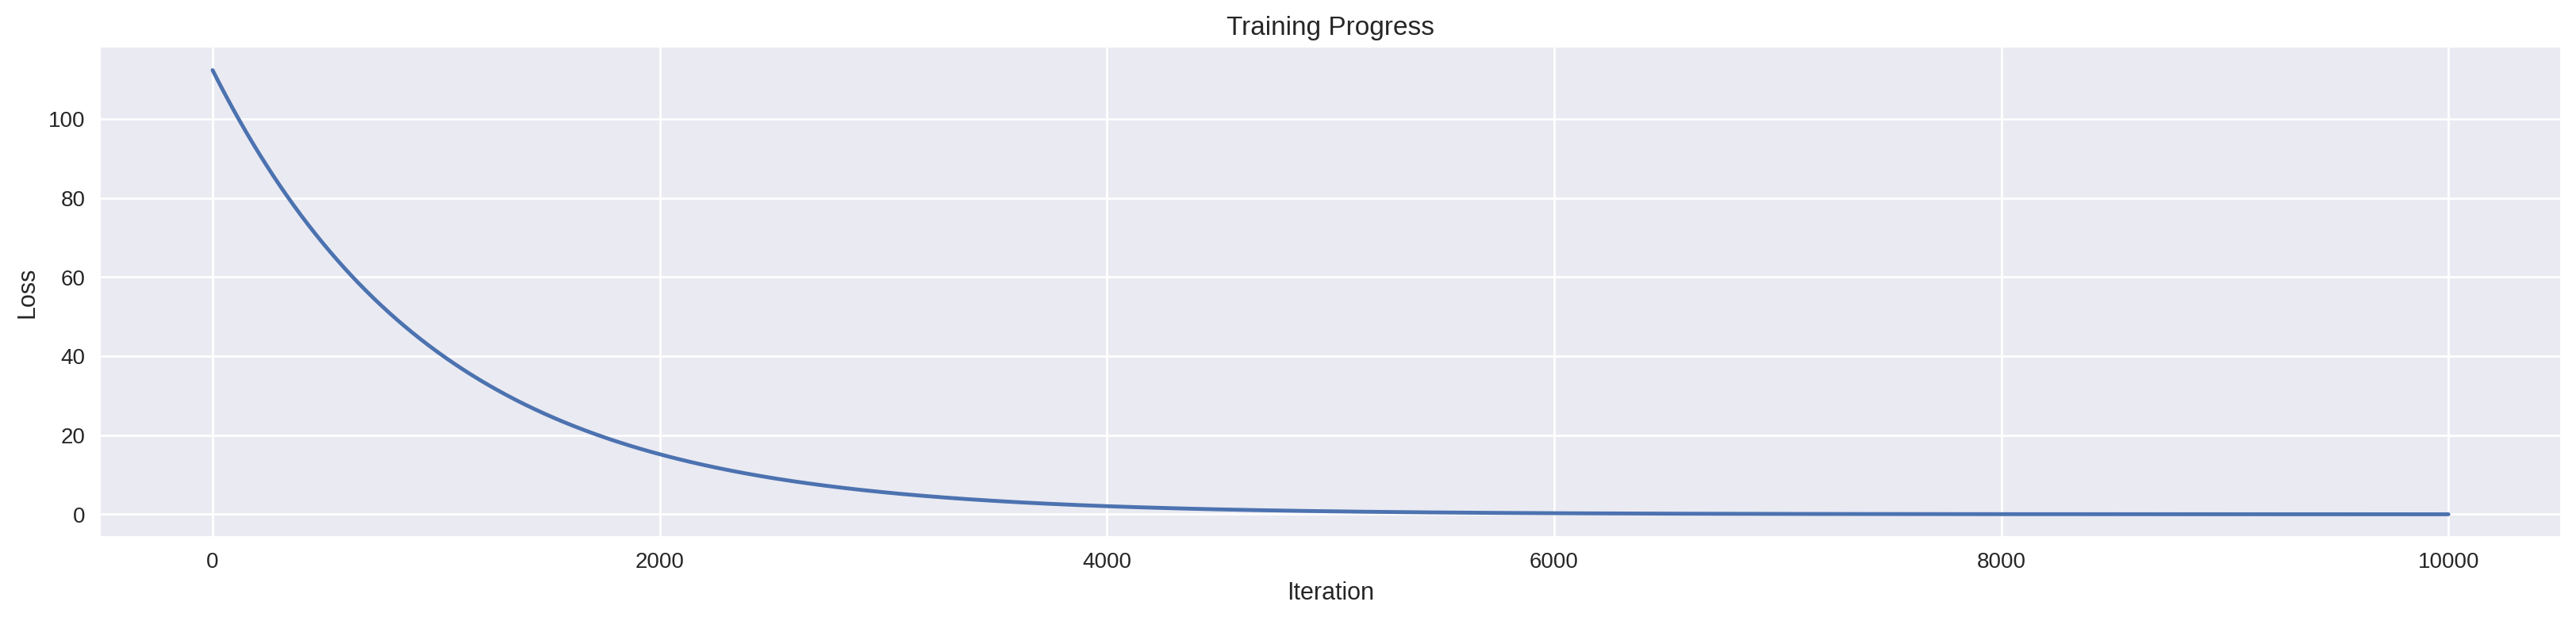

In [17]:
plt.figure(figsize=(20, 4))
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

### __TEST DIFFERENT SEEDS__

In [18]:
seed_words = ['The', 'he', 'thirsty', 'wood', 'shiny']
for word in seed_words:
    generated_word = sample(word, n_words=150)
    print(word, ':', generated_word)
    print("-" * 60)

The : the water at the bottom , but his beak could not reach it . the crow thought for a moment . then he got an idea ! he started picking up small pebbles one by one and dropped them into the pitcher . slowly , the water began to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping
------------------------------------------------------------
he : he could not reach it . the crow thought for a moment . then he got an idea ! he started picking up small pebbles one by one and dropped the

In [19]:
# Different seed words from vocabulary
seed_words = ['the', 'a', 'crow', 'water', 'once']
for word in seed_words:
    if word in word_to_ix:
        generated = sample(word, n_words=30, stop_at_eos=True)
        print(f"{word}: {generated}")
        print("-" * 60)
    else:
        print(f"'{word}' not in vocabulary, skipping...")
        print("-" * 60)

the: the water at the bottom , but his beak could not reach it . the crow thought for a moment . then he got an idea ! he started picking up
------------------------------------------------------------
a: a beak could not reach it . the crow thought for a moment . then he got an idea ! he started picking up small pebbles one by one and dropped
------------------------------------------------------------
crow: crow brightly , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow was feeling tired and weak . after flying
------------------------------------------------------------
water: water time , the crow finally saw a pitcher lying under a tree . he quickly flew down and looked inside . there was a little water at the bottom ,
------------------------------------------------------------
once: once upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow
----------------

In [20]:
# Test with SOS token (no seed word)
for i in range(3):
    generated = sample(seed_word=None, n_words=30, use_sos=True, stop_at_eos=True)
    print(f"Sample {i+1}: {generated}")
    print("-" * 60)


Sample 1: , . after flying for a long time , the crow finally saw a pitcher lying under a tree . he quickly flew down and looked inside . there was
------------------------------------------------------------
Sample 2: pitcher . the crow continued dropping stones until the water came to rise . the crow continued dropping stones until the water came to rise . the crow continued dropping
------------------------------------------------------------
Sample 3: , . after flying for a long time , the crow finally saw a pitcher lying under a tree . he quickly flew down and looked inside . there was
------------------------------------------------------------


In [21]:
# Test with unknown word
generated = sample('elephant', n_words=30, stop_at_eos=True)
print(f"elephant: {generated}")
print("=" * 60)

elephant: <UNK> happily the crow thought for a moment . then he got an idea ! he started picking up small pebbles one by one and dropped them into the pitcher .


### __UNDERSTANDING SPECIAL TOKENS IN ACTION__

**Why Special Tokens Matter:**

1. **`<SOS>` (Start of Sequence)**
   - Signals the beginning of text generation
   - Helps model learn how stories/sentences typically begin
   - Used when generating from scratch: `sample(seed_word=None, use_sos=True)`

2. **`<EOS>` (End of Sequence)**
   - Model learns natural stopping points
   - Prevents endless generation
   - Can control when generation stops: `sample(stop_at_eos=True)`
   - Example: "The crow drank the water <EOS>" → generation stops

3. **`<UNK>` (Unknown)**
   - Handles out-of-vocabulary words gracefully
   - At test time, unknown words → `<UNK>` token
   - Model still generates coherent text even with unknown inputs
   - Example: `sample('elephant')` → if 'elephant' not in vocab, uses `<UNK>`

**Use Case:**
```python
# Real-world scenario: User input might contain unseen words
user_input = "quantum physics"  # 'quantum' might not be in training vocab
generated = sample('quantum', n_words=20, stop_at_eos=True)
# Model uses <UNK> for 'quantum' but still generates sensible continuation
```

**Benefits:**
- **Robustness**: Handles unexpected inputs
- **Control**: Can stop generation naturally
- **Flexibility**: Generate from scratch or with seed words

## **SUMMARY**
### **Key Takeaways:**
1. **Word Embeddings**: Dense vector representations replace sparse one-hot encoding, enabling efficient learning for large vocabularies
2. **Special Tokens**: `<SOS>`, `<EOS>`, and `<UNK>` tokens make the model robust and production-ready
3. **Hidden State = Memory**: The hidden state $\mathbf{h}_t$ encodes all information seen so far across word sequences
4. **BPTT with Embeddings**: Backpropagation flows through time and through the embedding layer, updating only relevant word vectors
5. **Controlled Generation**: Can start from scratch (`<SOS>`), stop naturally (`<EOS>`), or handle unknown words (`<UNK>`)

### **Word-Level vs Character-Level:**
| Aspect | Character-Level | Word-Level |
|--------|----------------|------------|
| **Vocabulary Size** | Small (~50-100) | Large (1,000-100,000+) |
| **Input Representation** | One-hot vectors | Learned embeddings |
| **Generation Speed** | Slower (more timesteps) | Faster (fewer timesteps) |
| **Creativity** | Can create new words | Limited to known words |
| **Grammar** | Must learn from scratch | Better structure naturally |
| **Memory Efficiency** | Low (small vocab) | High (sparse embedding updates) |
| **Special Tokens** | Less critical | Essential for robustness |

### **Modern Improvements:**
- **LSTMs (Long Short-Term Memory)**: Solve vanishing gradient with gating mechanisms  
- **GRUs (Gated Recurrent Units)**: Simpler than LSTM, similar performance
- **Pre-trained Embeddings**: Use Word2Vec, GloVe, or FastText for better initialization
- **Subword Tokenization**: BPE, WordPiece handle OOV words (BERT, GPT)
- **Transformers**: Use attention, fully parallelizable, now dominant in NLP  


### **References:**
1. Karpathy, A. (2015). *The Unreasonable Effectiveness of RNNs*. [Blog Post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
2. Elman, J. (1990). *Finding Structure in Time*. Cognitive Science, 14(2), 179-211.
3. Mikolov, T., et al. (2013). *Efficient Estimation of Word Representations in Vector Space*. arXiv:1301.3781.
4. Rumelhart, D. E., et al. (1986). *Learning representations by back-propagating errors*. Nature, 323(6088), 533-536.
5. Kingma, D. P., & Ba, J. (2014). *Adam: A Method for Stochastic Optimization*. arXiv:1412.6980.

### **Further Reading:**
1. Karpathy, A. (2015). [The Unreasonable Effectiveness of RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
2. Mikolov, T., et al. (2013). [Word2Vec Paper](https://arxiv.org/abs/1301.3781)
3. Hochreiter & Schmidhuber (1997). Long Short-Term Memory. Neural Computation.
4. Cho et al. (2014). Learning Phrase Representations using RNN Encoder-Decoder for SMT.
5. Vaswani et al. (2017). Attention Is All You Need. NeurIPS.
6. Goodfellow et al. (2016). Deep Learning. Chapter 10: Sequence Modeling.